In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [19]:
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
        "oldpeak","slope","ca","thal","target"]

df = pd.read_csv("processed.cleveland.data", names=cols)

In [20]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [21]:
df.replace("?", np.nan, inplace=True)

In [22]:
df.dropna(inplace=True)

In [23]:
df = df.astype(float)

In [24]:
df["target"] = (df["target"] > 0).astype(int)

In [25]:
X, y = df.drop("target", axis=1), df["target"]
X = StandardScaler().fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=4, random_state=42)
}

In [28]:
results = {}

In [29]:
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    
    print(f"\n{name} Results:")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print("ROC-AUC:", roc)
    print("CV Accuracy: %.3f ± %.3f" % (scores.mean(), scores.std()))
    
    results[name] = {"ROC-AUC": roc, "CV Mean": scores.mean(), "CV Std": scores.std()}


Logistic Regression Results:
[[32  4]
 [ 4 20]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

ROC-AUC: 0.9421296296296298
CV Accuracy: 0.825 ± 0.032

Decision Tree Results:
[[27  9]
 [ 4 20]]
              precision    recall  f1-score   support

           0       0.87      0.75      0.81        36
           1       0.69      0.83      0.75        24

    accuracy                           0.78        60
   macro avg       0.78      0.79      0.78        60
weighted avg       0.80      0.78      0.79        60

ROC-AUC: 0.8848379629629629
CV Accuracy: 0.751 ± 0.056


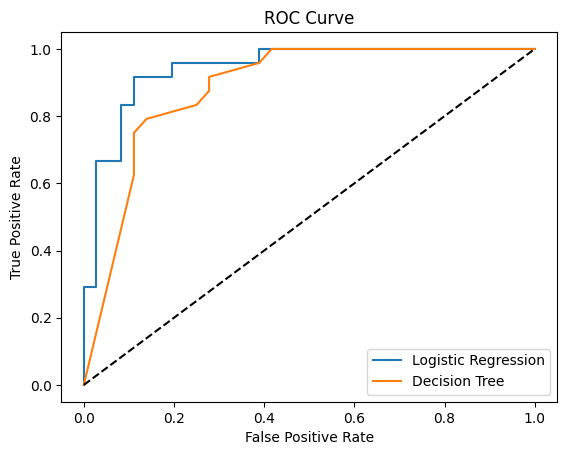

In [30]:
plt.figure()
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

In [31]:
print("\nModel Comparison:")
for name, vals in results.items():
    print(f"{name:20s} | ROC-AUC: {vals['ROC-AUC']:.3f} | CV Acc: {vals['CV Mean']:.3f} ± {vals['CV Std']:.3f}")


Model Comparison:
Logistic Regression  | ROC-AUC: 0.942 | CV Acc: 0.825 ± 0.032
Decision Tree        | ROC-AUC: 0.885 | CV Acc: 0.751 ± 0.056


Observations:

Logistic Regression is more interpretable (coefficients show risk factors).

Decision Tree is easier to explain visually but may overfit small datasets.

Cross-validation shows which model is more consistent across folds.

Clinical use: Logistic Regression preferred for interpretability; Tree for explainability.